In [1]:
from sea_breeze import load_model_data, sea_breeze_funcs, sea_breeze_filters
from dask.distributed import Client
from dask.distributed import progress
import pandas as pd
import os
import argparse
import metpy.calc as mpcalc

In [2]:
client = Client()
client

2024-12-27 10:59:48,828 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-12-27 10:59:48,831 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-12-27 10:59:48,868 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0035.gadi.nci.org.au/8454/proxy/8787/status,
Dashboard: /node/gadi-cpu-bdw-0035.gadi.nci.org.au/8454/proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43403,Workers: 28
Dashboard: /node/gadi-cpu-bdw-0035.gadi.nci.org.au/8454/proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35453,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0035.gadi.nci.org.au/8454/proxy/39559/status,Memory: 0 B
Nanny: tcp://127.0.0.1:37507,


In [3]:
lat_slice=slice(-45.7,-6.9)
lon_slice=slice(108,158.5)
t1="2016-01-01 00:00"
t2="2016-01-31 23:00"

In [8]:
chunks = {"time":-1,"lat":100,"lon":100}
orog, lsm = load_model_data.load_barra_static(
    "AUST-04",
    lon_slice,
    lat_slice)
vas = load_model_data.load_barra_variable(
        "vas",
        t1,
        t2,
        "AUST-04",
        "1hr",
        lat_slice,
        lon_slice,
        chunks=chunks)
uas = load_model_data.load_barra_variable(
        "uas",
        t1,
        t2,
        "AUST-04",
        "1hr",
        lat_slice,
        lon_slice,
        chunks=chunks)
huss = load_model_data.load_barra_variable(
        "huss",
        t1,
        t2,
        "AUST-04",
        "1hr",
        lat_slice,
        lon_slice,
        chunks=chunks)
tas = load_model_data.load_barra_variable(
        "tas",
        t1,
        t2,
        "AUST-04",
        "1hr",
        lat_slice,
        lon_slice,
        chunks=chunks)     
angle_ds = load_model_data.get_coastline_angle_kernel(
    lsm,
    compute=False,
    lat_slice=lat_slice,
    lon_slice=lon_slice,
    path_to_load="/g/data/gb02/ab4502/coastline_data/barra_c.nc")


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/pyth

In [9]:
huss

<xarray.DataArray 'huss' (time: 744, lat: 970, lon: 1263)> Size: 7GB
dask.array<getitem, shape=(744, 970, 1263), dtype=float64, chunksize=(744, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time                (time) datetime64[ns] 6kB 2016-01-01 ... 2016-01-31T2...
  * lat                 (lat) float64 8kB -45.69 -45.65 -45.61 ... -6.97 -6.93
  * lon                 (lon) float64 10kB 108.0 108.1 108.1 ... 158.5 158.5
    level_height        float64 8B ...
    model_level_number  int32 4B ...
    sigma               float64 8B ...
    height              float64 8B ...
    crs                 int32 4B ...
Attributes:
    long_name:      Near-Surface Specific Humidity
    standard_name:  specific_humidity
    units:          1
    cell_methods:   time: point (interval: 1H)
    grid_mapping:   crs

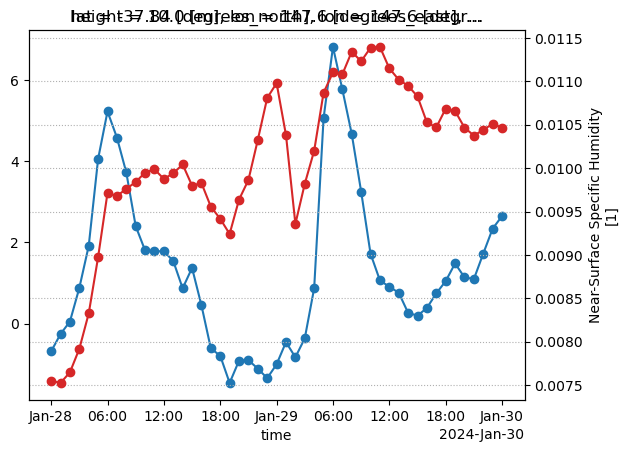

In [6]:
vprime.sel(lat=-37.881802,lon=147.566895,method="nearest").plot(marker="o")
plt.gca().twinx()
q.sel(lat=-37.881802,lon=147.566895,method="nearest").plot(marker="o",color="tab:red")
plt.gca().grid(ls=":",axis="both")

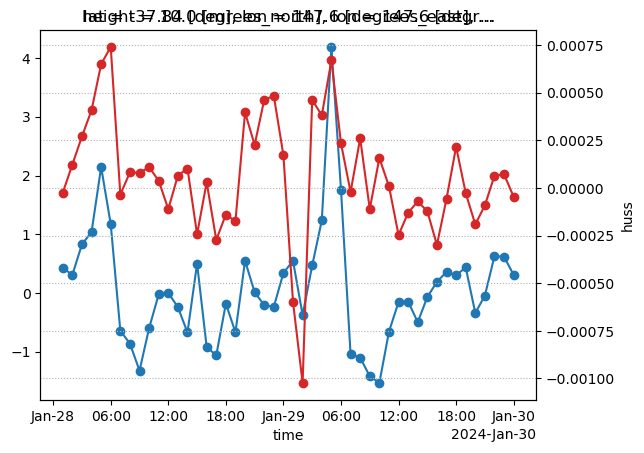

In [7]:
vprime.sel(lat=-37.881802,lon=147.566895,method="nearest").diff("time").plot(marker="o")
plt.gca().twinx()
q.sel(lat=-37.881802,lon=147.566895,method="nearest").diff("time").plot(marker="o",color="tab:red")
plt.gca().grid(ls=":",axis="both")

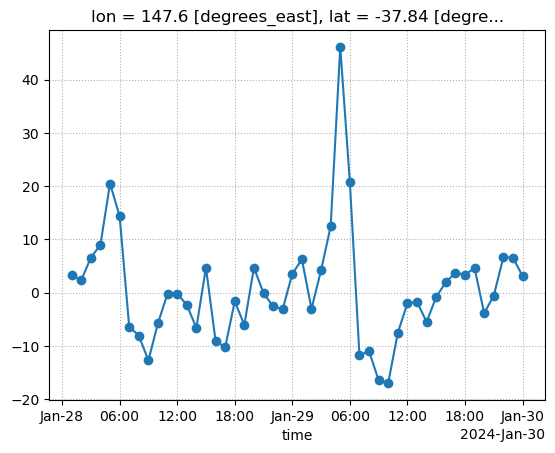

In [8]:
(vprime*(q*1000)).sel(lat=-37.881802,lon=147.566895,method="nearest").diff("time").plot(marker="o")
plt.gca().grid(ls=":",axis="both")

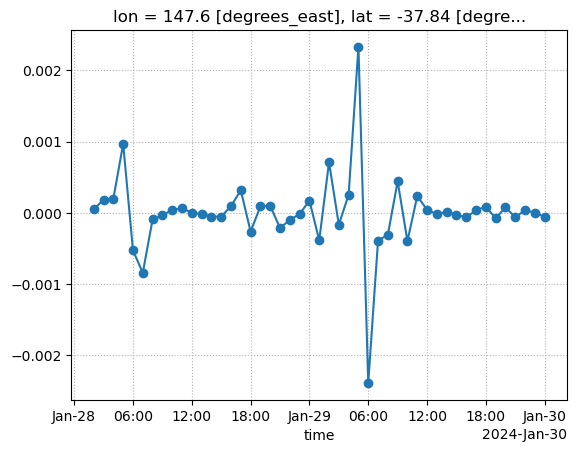

In [9]:
(vprime.diff(dim="time") * q.diff(dim="time")).sel(lat=-37.881802,lon=147.566895,method="nearest").diff("time").plot(marker="o")
plt.gca().grid(ls=":",axis="both")

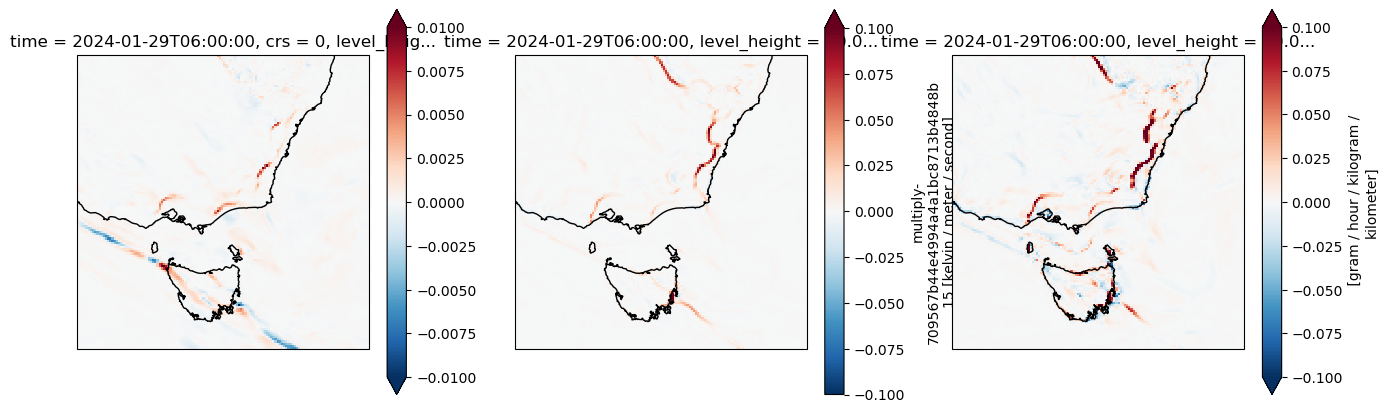

In [15]:
plt.figure(figsize=[16,5])

ax=plt.subplot(1,3,1,projection=ccrs.PlateCarree())
(vprime.diff(dim="time") * q.diff(dim="time")).sel(time="2024-01-29 06:00").plot(vmin=-0.01,vmax=0.01,cmap="RdBu_r")
ax.coastlines()

ax=plt.subplot(1,3,2,projection=ccrs.PlateCarree())
kinematic_frontogenesis(q.sel(time="2024-01-29 06:00")
                        ,u.sel(time="2024-01-29 06:00")
                        ,v.sel(time="2024-01-29 06:00")).plot(vmin=-0.1,vmax=0.1,cmap="RdBu_r")
ax.coastlines()

ax=plt.subplot(1,3,3,projection=ccrs.PlateCarree())
f = coast_relative_frontogenesis(q.sel(time="2024-01-29 06:00")
                        ,u.sel(time="2024-01-29 06:00")
                        ,v.sel(time="2024-01-29 06:00")
                        ,angle_ds)
(f.shearing+f.confluence).plot(vmin=-0.1,vmax=0.1,cmap="RdBu_r")
ax.coastlines()

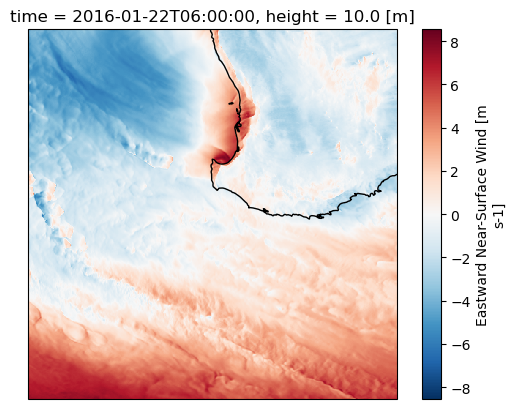

In [58]:
ax=plt.axes(projection=ccrs.PlateCarree())
aus2200["uas"].sel(time="2016-01-22 06:00").uas.plot()
ax.coastlines()